# Applied AI Assessment Student ID 202209876
## Comparative Analysis of Deep-Learning Algorithms in Age Prediction

    Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import numpy as np
import tensorflow as tf

warnings.filterwarnings('ignore')

%matplotlib inline

from PIL import Image, ImageFilter
from tqdm import tqdm
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import imagenet_utils
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from keras.applications.resnet import preprocess_input
from sklearn.metrics import mean_absolute_error, mean_squared_error

    Load Dataset

In [2]:
# Define the base directory path
base_directory = r"C:\Users\abiol\Downloads\Applied Artificial Intelligence\UTKFace"

# List all files in the directory
file_list = os.listdir(base_directory)

# Print the list of files
for filename in file_list:
    print(filename)

10_0_0_20170117135444407.jpg.chip.jpg
10_0_0_20170117143048181.jpg.chip.jpg
10_0_0_20170117175625724.jpg.chip.jpg
10_0_0_20170120220628194.jpg.chip.jpg
10_0_1_20170104010841239.jpg.chip.jpg
10_0_1_20170110220507258.jpg.chip.jpg
10_0_1_20170110220523360.jpg.chip.jpg
10_0_1_20170110223455893.jpg.chip.jpg
10_0_1_20170110223848885.jpg.chip.jpg
10_0_1_20170110225121326.jpg.chip.jpg
10_0_1_20170110225339066.jpg.chip.jpg
10_0_1_20170116225209209.jpg.chip.jpg
10_0_2_20170110224230094.jpg.chip.jpg
10_0_2_20170116162109013.jpg.chip.jpg
10_0_3_20161220215952636.jpg.chip.jpg
10_0_3_20170104225233504.jpg.chip.jpg
10_0_3_20170104225238736.jpg.chip.jpg
10_0_3_20170105175322885.jpg.chip.jpg
10_0_4_20161221192738446.jpg.chip.jpg
10_0_4_20170103200335831.jpg.chip.jpg
10_0_4_20170103200409638.jpg.chip.jpg
10_0_4_20170103200443015.jpg.chip.jpg
10_0_4_20170103200501766.jpg.chip.jpg
10_0_4_20170103201924664.jpg.chip.jpg
10_0_4_20170103202338152.jpg.chip.jpg
10_0_4_20170103212521420.jpg.chip.jpg
10_0_4_20170

    Preprocess Image

In [3]:
#labels; age
image_paths = []
age_labels = []

for filename in tqdm (os.listdir(base_directory)):
    image_path = os.path.join(base_directory, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

  0%|          | 0/23626 [00:00<?, ?it/s]

In [4]:
utkf_ds = pd.DataFrame()
utkf_ds['image'], utkf_ds['age'] = image_paths, age_labels
utkf_ds.head()

image  age
0  C:\Users\abiol\Downloads\Applied Artificial In...   10
1  C:\Users\abiol\Downloads\Applied Artificial In...   10
2  C:\Users\abiol\Downloads\Applied Artificial In...   10
3  C:\Users\abiol\Downloads\Applied Artificial In...   10
4  C:\Users\abiol\Downloads\Applied Artificial In...   10

    Data Exploration

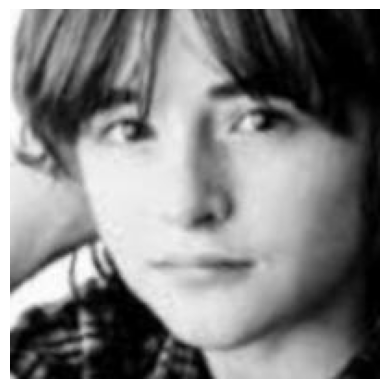

In [5]:
from PIL import Image
img = Image.open(utkf_ds['image'][0])
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

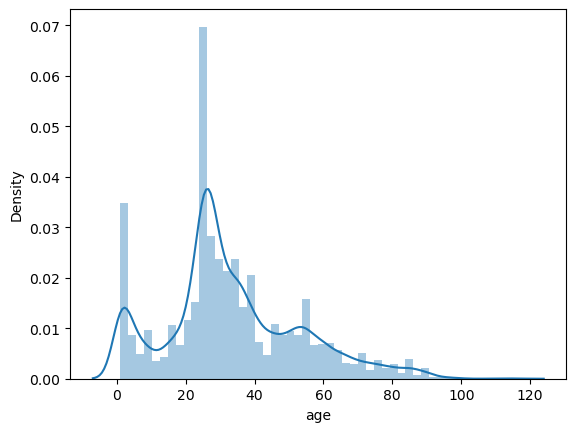

In [6]:
sns.distplot(utkf_ds['age'])

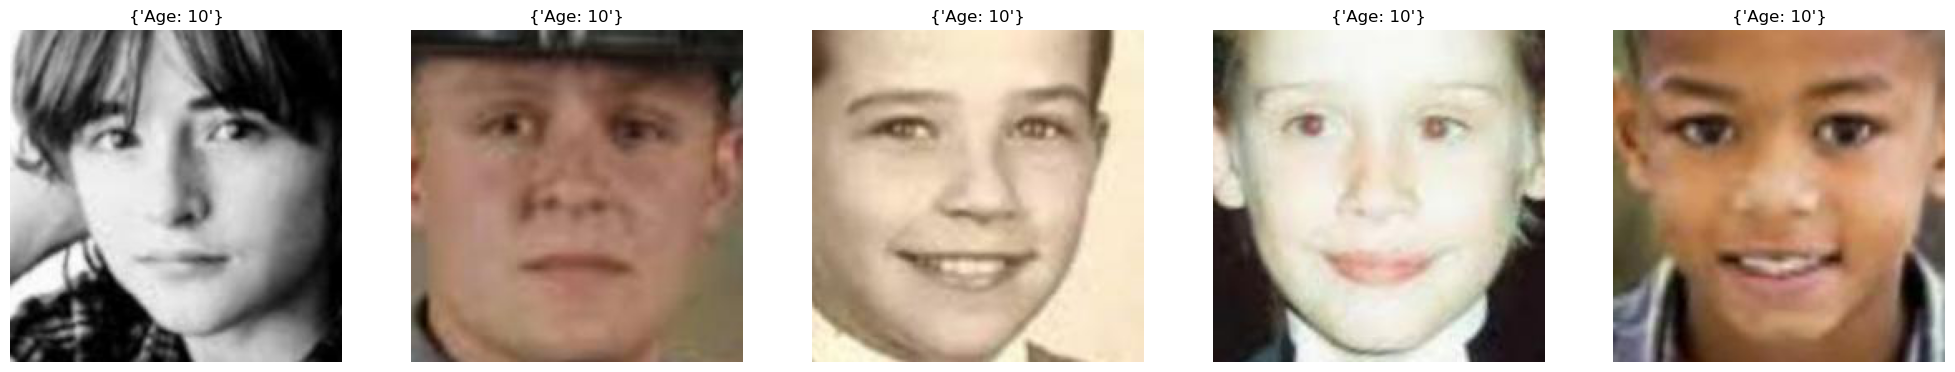

In [7]:
plt.figure(figsize = (25, 25))
files = utkf_ds.iloc[0:5]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title({f'Age: {age}'})
    plt.axis('off')

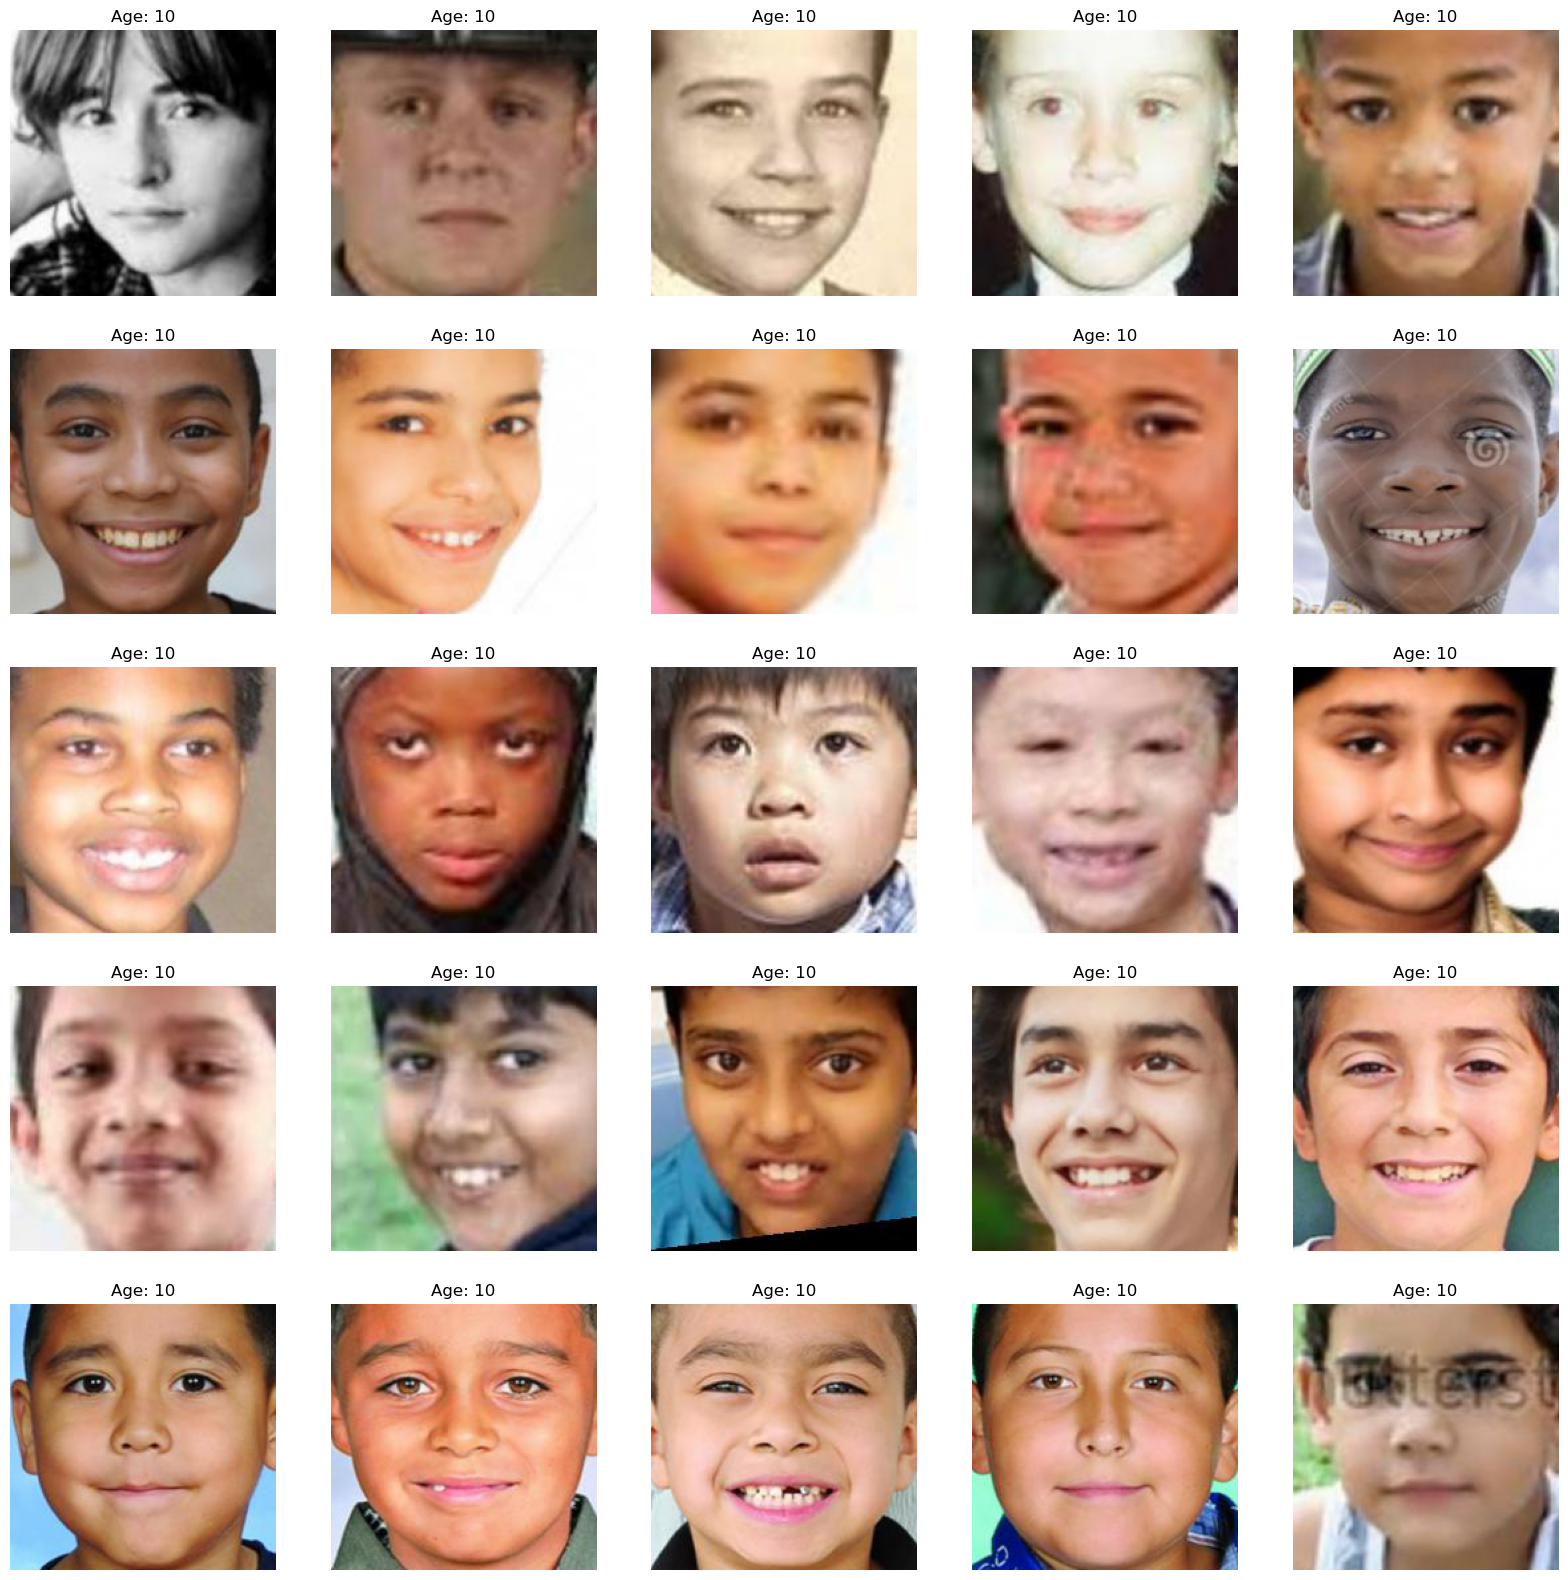

In [8]:
plt.figure(figsize=(20, 20))
files = utkf_ds.iloc[0:25]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

    Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images, desc="Extracting Features"):
        img = Image.open(image).convert("L")
        img = img.resize((128, 128), Image.LANCZOS)  # Use Image.LANCZOS as a filter for antialiasing
        img_array = np.array(img)
        features.append(img_array)
    
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_features(utkf_ds['image'])

Extracting Features:   0%|          | 0/23626 [00:00<?, ?it/s]

In [10]:
X.shape

(23626, 128, 128, 1)

In [11]:
# Normalize the images
X = X/255.0

In [12]:
# Parameters
batch_size = 32
target_size = (128, 128)

# List of image paths from dataset
image_paths = utkf_ds['image']

In [13]:
from sklearn.model_selection import train_test_split

# Load corresponding age labels (replace with your actual labels)
y = utkf_ds['age']

In [14]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18900, 128, 128, 1)
X_test shape: (4726, 128, 128, 1)
y_train shape: (18900,)
y_test shape: (4726,)


### Convolutional Neural Network (CNN) with extracted features:

In [16]:
# Create a CNN model architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

    Compilation

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

    Train the CNN Model

In [18]:
history_cnn = cnn_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
591/591 [==============================] - 236s 397ms/step - loss: 333.4351 - mae: 13.8755 - mse: 333.4351 - val_loss: 186.1563 - val_mae: 10.4113 - val_mse: 186.1563
Epoch 2/20
591/591 [==============================] - 246s 416ms/step - loss: 183.7112 - mae: 10.2425 - mse: 183.7112 - val_loss: 156.7075 - val_mae: 9.7192 - val_mse: 156.7075
Epoch 3/20
591/591 [==============================] - 232s 392ms/step - loss: 152.8422 - mae: 9.3122 - mse: 152.8422 - val_loss: 121.3256 - val_mae: 8.2654 - val_mse: 121.3256
Epoch 4/20
591/591 [==============================] - 248s 420ms/step - loss: 135.9537 - mae: 8.7380 - mse: 135.9537 - val_loss: 115.8879 - val_mae: 8.0696 - val_mse: 115.8879
Epoch 5/20
591/591 [==============================] - 241s 408ms/step - loss: 120.6438 - mae: 8.2457 - mse: 120.6438 - val_loss: 121.7844 - val_mae: 8.5281 - val_mse: 121.7844
Epoch 6/20
591/591 [==============================] - 249s 422ms/step - loss: 112.1248 - mae: 7.9143 - mse: 112.1248 

    Age Prediction using CNN

In [19]:
# Make predictions using the CNN model
y_pred_cnn = cnn_model.predict(X_test)

# Round the predicted ages
rounded_pred_cnn = y_pred_cnn.flatten().round()

# Create a DataFrame for comparison
cnn_comparison_ds = pd.DataFrame({'Actual Age': y_test, 'Predicted Age (CNN)': rounded_pred_cnn})

# Select 10 random rows from cnn_comparison_ds
random_selected_rows = cnn_comparison_ds.sample(n=10, random_state=200)

random_selected_rows


148/148 [==============================] - 17s 111ms/step


Actual Age  Predicted Age (CNN)
10741          30                 26.0
2189            1                  2.0
2950           21                 30.0
18857          54                 37.0
4156           24                 27.0
6726           26                 25.0
15834          41                 50.0
5163           25                 40.0
2712           20                 20.0
12553          34                 37.0

In [20]:
cnn_comparison_ds.head(10)

Actual Age  Predicted Age (CNN)
1474           19                 19.0
19472          56                 34.0
19788          58                 26.0
9526           29                 24.0
4788           24                 21.0
18217          51                 37.0
3100           21                 19.0
13361          35                 28.0
14084          37                 57.0
14798          39                 50.0

    Mean Absolute Error and Mean Squared Error (CNN)

In [21]:
# Calculate mean absolute error and mean squared error
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
print("Mean Absolute Error (CNN):", mae_cnn)
print("Mean Squared Error (CNN):", mse_cnn)

Mean Absolute Error (CNN): 6.930788039328736
Mean Squared Error (CNN): 90.22221499989486


In [114]:
# Make predictions on the training and testing sets
y_train_pred_cnn = cnn_model.predict(X_train)
y_test_pred_cnn = cnn_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_train_cnn = mean_absolute_error(y_train, y_train_pred_cnn)
mae_test_cnn = mean_absolute_error(y_test, y_test_pred_cnn)

# Calculate Mean Squared Error (MSE)
mse_train_cnn = mean_squared_error(y_train, y_train_pred_cnn)
mse_test_cnn = mean_squared_error(y_test, y_test_pred_cnn)

# Calculate Root Mean Squared Error (RMSE)
rmse_train_cnn = np.sqrt(mse_train_cnn)
rmse_test_cnn = np.sqrt(mse_test_cnn)

# Calculate Coefficient of Determination (R^2)
r2_train_cnn = r2_score(y_train, y_train_pred_cnn)
r2_test_cnn = r2_score(y_test, y_test_pred_cnn)

# Display the metrics
print("CNN Model Evaluation Metrics:")
print("Mean Absolute Error (MAE) Train:", mae_train_cnn)
print("Mean Absolute Error (MAE) Test:", mae_test_cnn)
print("Mean Squared Error (MSE) Train:", mse_train_cnn)
print("Mean Squared Error (MSE) Test:", mse_test_cnn)
print("Root Mean Squared Error (RMSE) Train:", rmse_train_cnn)
print("Root Mean Squared Error (RMSE) Test:", rmse_test_cnn)
print("Coefficient of Determination (R^2) Train:", r2_train_cnn)
print("Coefficient of Determination (R^2) Test:", r2_test_cnn)


148/148 [==============================] - 19s 126ms/step
CNN Model Evaluation Metrics:
Mean Absolute Error (MAE) Train: 4.128024580308369
Mean Absolute Error (MAE) Test: 6.930788039328736
Mean Squared Error (MSE) Train: 29.83262170841084
Mean Squared Error (MSE) Test: 90.22221499989486
Root Mean Squared Error (RMSE) Train: 5.461924725626567
Root Mean Squared Error (RMSE) Test: 9.498537519002326
Coefficient of Determination (R^2) Train: 0.9235829190671172
Coefficient of Determination (R^2) Test: 0.7724248233841413


In [113]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

    Plot training loss and validation loss

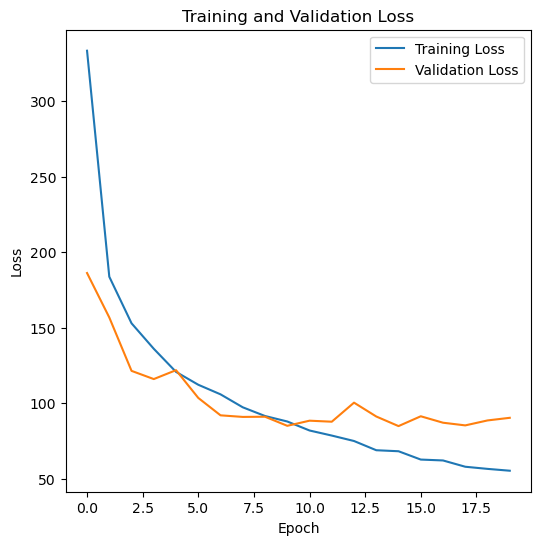

In [22]:
plt.figure(figsize=(6, 6))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('Training and Validation Loss Plot')
plt.show()



    Predicting with Test Image

In [97]:
test_image1 = Image.open("tinubu_gray.jpg")
test_image2 = Image.open("angelina_jolie_gray.jpg")
test_image3 = Image.open("dwayne_johnson_gray.jpg")
test_image4 = Image.open("donald_trump_gray.jpg")
test_image5 = Image.open("adele_gray.jpg")
test_image6 = Image.open("joe_biden_gray.jpg")
test_image7 = Image.open("obama_gray.jpg")
test_image8 = Image.open("rihanna_gray.jpg")
test_image9 = Image.open("queen_elizabeth_gray.jpg")
test_image10 = Image.open("martins_gray.jpg")

1/1 [==============================] - 0s 55ms/step


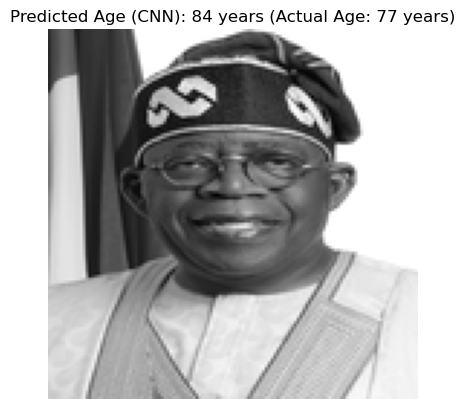

In [86]:
# Resize the image to 128x128 pixels
test_image1 = test_image1.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image1)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 77 

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image1")
plt.show()


1/1 [==============================] - 0s 57ms/step


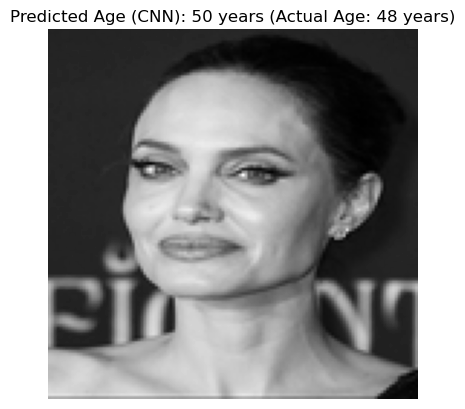

In [87]:
# Resize the image to 128x128 pixels
test_image2 = test_image2.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image2)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 48 

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image2")
plt.show()


1/1 [==============================] - 0s 52ms/step


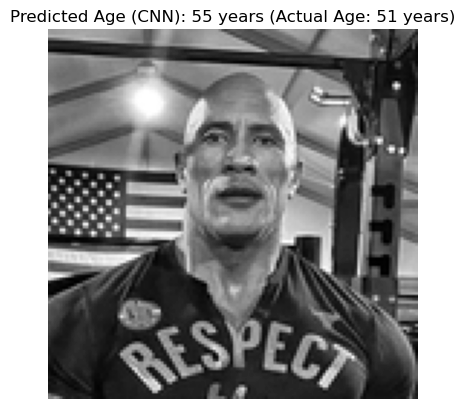

In [88]:
# Resize the image to 128x128 pixels
test_image3 = test_image3.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image3)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 51 

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image3")
plt.show()


1/1 [==============================] - 0s 50ms/step


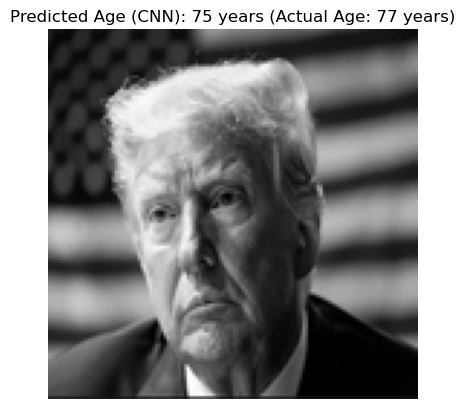

In [89]:
# Resize the image to 128x128 pixels
test_image4 = test_image4.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image4)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 77

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image4")
plt.show()


1/1 [==============================] - 0s 145ms/step


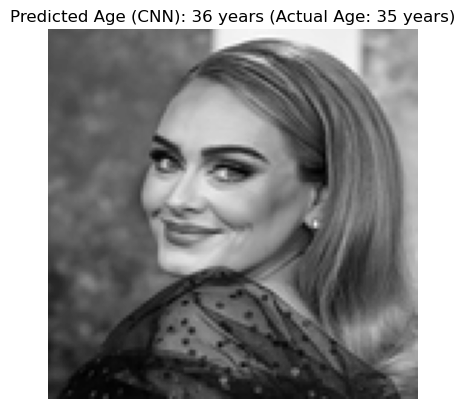

In [90]:
# Resize the image to 128x128 pixels
test_image5 = test_image5.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image5)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 35

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image5")
plt.show()


1/1 [==============================] - 0s 49ms/step


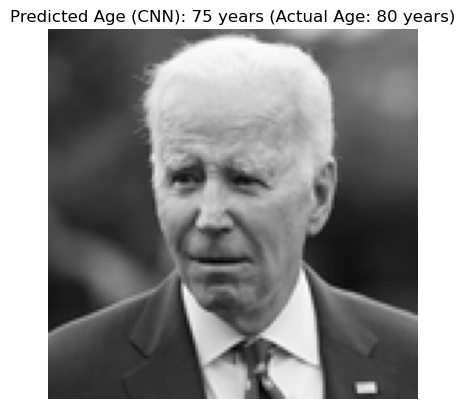

In [91]:
# Resize the image to 128x128 pixels
test_image6 = test_image6.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image6)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 80

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image6")
plt.show()


1/1 [==============================] - 0s 53ms/step


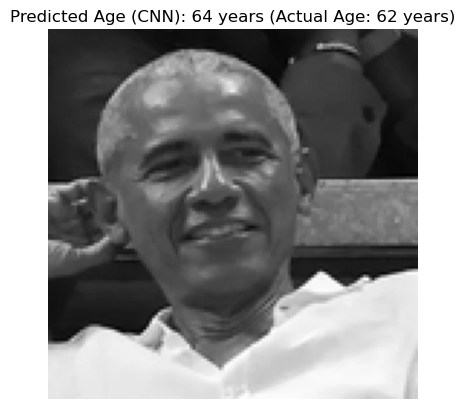

In [98]:
# Resize the image to 128x128 pixels
test_image7 = test_image7.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image7)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 62 

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image7")
plt.show()


1/1 [==============================] - 0s 54ms/step


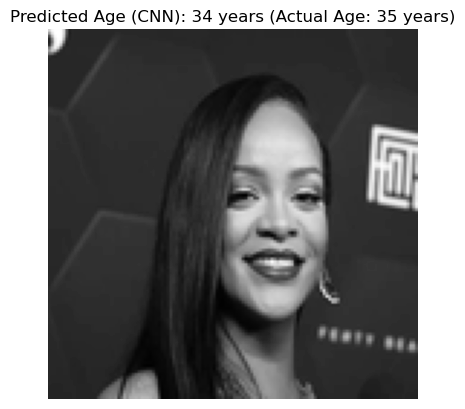

In [93]:
# Resize the image to 128x128 pixels
test_image8 = test_image8.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image8)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 35

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image8")
plt.show()


1/1 [==============================] - 0s 64ms/step


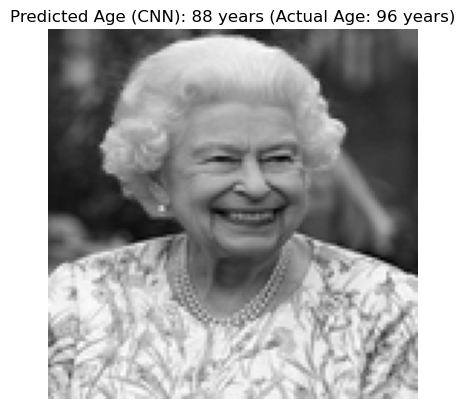

In [94]:
# Resize the image to 128x128 pixels
test_image9 = test_image9.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image9)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 96 

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image9")
plt.show()


1/1 [==============================] - 0s 50ms/step


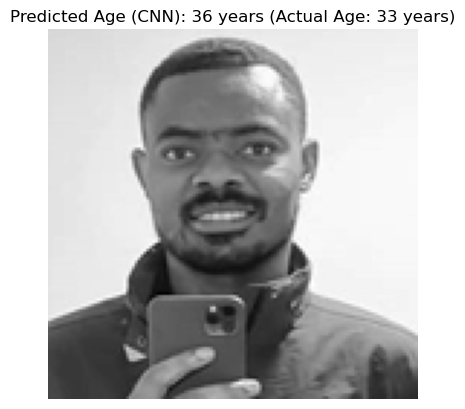

In [95]:
# Resize the image to 128x128 pixels
test_image10 = test_image10.resize((128, 128), Image.LANCZOS)

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image10)

# Normalize the image
test_image_array = test_image_array / 255.0

# Reshape the image to match the input shape expected
test_image_array = test_image_array.reshape(1, 128, 128, 1)

# Make the age prediction using the CNN model
predicted_age = cnn_model.predict(test_image_array)[0][0]

# Actual age of the test image
actual_age = 33 

# Display the image with the predicted age as the label
plt.imshow(test_image_array[0].squeeze(), cmap='gray')
plt.title("Predicted Age (CNN): {:.0f} years (Actual Age: {} years)".format(predicted_age, actual_age))
plt.axis('off')
plt.savefig("CNN Age Prediction with Test Image10")
plt.show()


### Random Forest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Reshape the training and testing data to be two-dimensional
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize the RandomForestRegressor with desired parameters
forest_reg = RandomForestRegressor(n_estimators=1000, random_state=2, n_jobs=-1, max_depth=4)

# Fit the model to the training data
forest_reg.fit(X_train_flat, y_train)

forest_reg.max_depth = 3

# Predict age on the training and testing sets
y_train_pred = forest_reg.predict(X_train_flat)
y_test_pred = forest_reg.predict(X_test_flat)

# Calculate evaluation metrics

# Mean squared error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Root mean squared error
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Mean absolute error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Coefficient of determination (R-squared)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("*** Random Forest Regression Results ***\n")
print(f"Mean Absolute Error Train: {mae_train:.2f}")
print(f"Mean Absolute Error Test: {mae_test:.2f}\n")

print(f"Mean Squared Error Train: {mse_train:.2f}")
print(f"Mean Squared Error Test: {mse_test:.2f}\n")

print(f"Root Mean Squared Error Train: {rmse_train:.2f}")
print(f"Root Mean Squared Error Test: {rmse_test:.2f}\n")

print(f"Coefficient of Determination Train: {r2_train:.2f}")
print(f"Coefficient of Determination Test: {r2_test:.2f}")


*** Random Forest Regression Results ***

Mean Absolute Error Train: 12.44
Mean Absolute Error Test: 12.77

Mean Squared Error Train: 262.24
Mean Squared Error Test: 282.16

Root Mean Squared Error Train: 16.19
Root Mean Squared Error Test: 16.80

Coefficient of Determination Train: 0.33
Coefficient of Determination Test: 0.29


    Age Prediction using RFR:

In [122]:
# Make predictions using the RFR model
y_pred_rfr = forest_reg.predict(X_test_flat)

# Round the predicted ages
rounded_pred_rfr = y_pred_rfr.round()

# Create a DataFrame for comparison
rfr_comparison_df = pd.DataFrame({'Actual Age': y_test, 'Predicted Age (RFR)': rounded_pred_rfr})
rfr_comparison_df.head(10)


Actual Age  Predicted Age (RFR)
1474           19                 29.0
19472          56                 30.0
19788          58                 39.0
9526           29                 34.0
4788           24                 41.0
18217          51                 35.0
3100           21                 32.0
13361          35                 31.0
14084          37                 33.0
14798          39                 35.0

    Predicting with Test Image

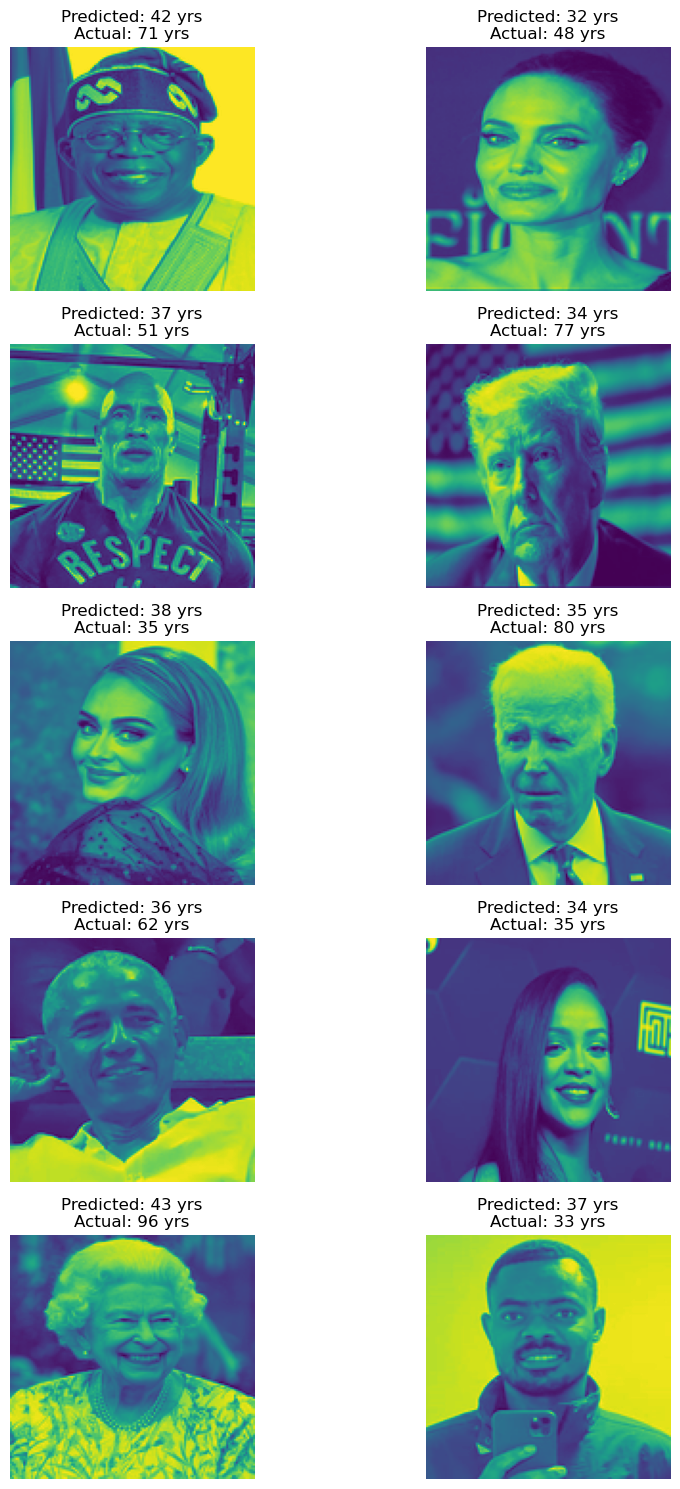

In [109]:
# List of test image file names and actual ages
test_images = [
    {"file_name": "tinubu_gray.jpg", "actual_age": 71},
    {"file_name": "angelina_jolie_gray.jpg", "actual_age": 48},
    {"file_name": "dwayne_johnson_gray.jpg", "actual_age": 51},
    {"file_name": "donald_trump_gray.jpg", "actual_age": 77},
    {"file_name": "adele_gray.jpg", "actual_age": 35},
    {"file_name": "joe_biden_gray.jpg", "actual_age": 80},
    {"file_name": "obama_gray.jpg", "actual_age": 62},
    {"file_name": "rihanna_gray.jpg", "actual_age": 35},
    {"file_name": "queen_elizabeth_gray.jpg", "actual_age": 96},
    {"file_name": "martins_gray.jpg", "actual_age": 33}
]

# Calculate the number of rows and columns for the subplot grid
num_images = len(test_images)
num_rows = (num_images + 1) // 2 
num_cols = 2

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Initialize a counter for subplot placement
plot_counter = 0

# Loop through test images
for test_image_info in test_images:
    # Load and preprocess the test image
    image_path = test_image_info["file_name"]
    test_image = Image.open(image_path)
    test_image = test_image.resize((128, 128), Image.LANCZOS)
    test_image_array = img_to_array(test_image)
    test_image_array = test_image_array / 255.0
    test_image_flat = test_image_array.reshape(1, -1)

    # Make the age prediction using the RFR model
    predicted_age = forest_reg.predict(test_image_flat)[0]

    # Actual age of the test image
    actual_age = test_image_info["actual_age"]

    # Display the image with predicted and actual age as label
    axs[plot_counter // 2, plot_counter % 2].imshow(test_image)
    axs[plot_counter // 2, plot_counter % 2].set_title(f"Predicted: {int(predicted_age)} yrs\nActual: {actual_age} yrs")
    axs[plot_counter // 2, plot_counter % 2].axis('off')

    # Increment the subplot counter
    plot_counter += 1

# If there is an odd number of images, remove the empty subplot
if num_images % 2 != 0:
    fig.delaxes(axs[num_rows - 1, num_cols - 1])

# Show the subplot grid
plt.tight_layout()
plt.savefig("RFR_Age_Prediction_with_Images.png")
plt.show()


In [117]:
# Print the hyperparameters of the RFR model
print("Random Forest Regression Hyperparameters:")
print("Number of Estimators:", forest_reg.n_estimators)
print("Random State:", forest_reg.random_state)
print("Max Depth:", forest_reg.max_depth) 


Random Forest Regression Hyperparameters:
Number of Estimators: 1000
Random State: 2
Max Depth: 3


### Support Vector Machine (SVM)

In [43]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Reshape the training and testing data to be two-dimensional
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize the SVR model with desired parameters
svm_model = SVR()

# Fit the model to the training data
svm_model.fit(X_train_flat, y_train)

# Predict age on the training and testing sets
y_train_pred = svm_model.predict(X_train_flat)
y_test_pred = svm_model.predict(X_test_flat)

# Calculate evaluation metrics

# Mean squared error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Root mean squared error
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Mean absolute error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Coefficient of determination (R-squared)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("*** Support Vector Machine (SVM) Regression Results ***\n")
print(f"Mean Absolute Error Train: {mae_train:.2f}")
print(f"Mean Absolute Error Test: {mae_test:.2f}\n")

print(f"Mean Squared Error Train: {mse_train:.2f}")
print(f"Mean Squared Error Test: {mse_test:.2f}\n")

print(f"Root Mean Squared Error Train: {rmse_train:.2f}")
print(f"Root Mean Squared Error Test: {rmse_test:.2f}\n")

print(f"Coefficient of Determination Train: {r2_train:.2f}")
print(f"Coefficient of Determination Test: {r2_test:.2f}")


*** Support Vector Machine (SVM) Regression Results ***

Mean Absolute Error Train: 10.47
Mean Absolute Error Test: 10.89

Mean Squared Error Train: 218.81
Mean Squared Error Test: 234.46

Root Mean Squared Error Train: 14.79
Root Mean Squared Error Test: 15.31

Coefficient of Determination Train: 0.44
Coefficient of Determination Test: 0.41


    Age Prediction using SVM:

In [123]:
# Make predictions using the SVM model
y_pred_svm = svm_model.predict(X_test_flat)

# Round the predicted ages
rounded_pred_svm = y_pred_svm.round()

# Create a DataFrame for comparison
svm_comparison_df = pd.DataFrame({'Actual Age': y_test, 'Predicted Age (SVM)': rounded_pred_svm})
svm_comparison_df.head(10)


Actual Age  Predicted Age (SVM)
1474           19                 23.0
19472          56                 29.0
19788          58                 31.0
9526           29                 37.0
4788           24                 27.0
18217          51                 31.0
3100           21                 30.0
13361          35                 34.0
14084          37                 34.0
14798          39                 31.0

    Predicting with Test Image


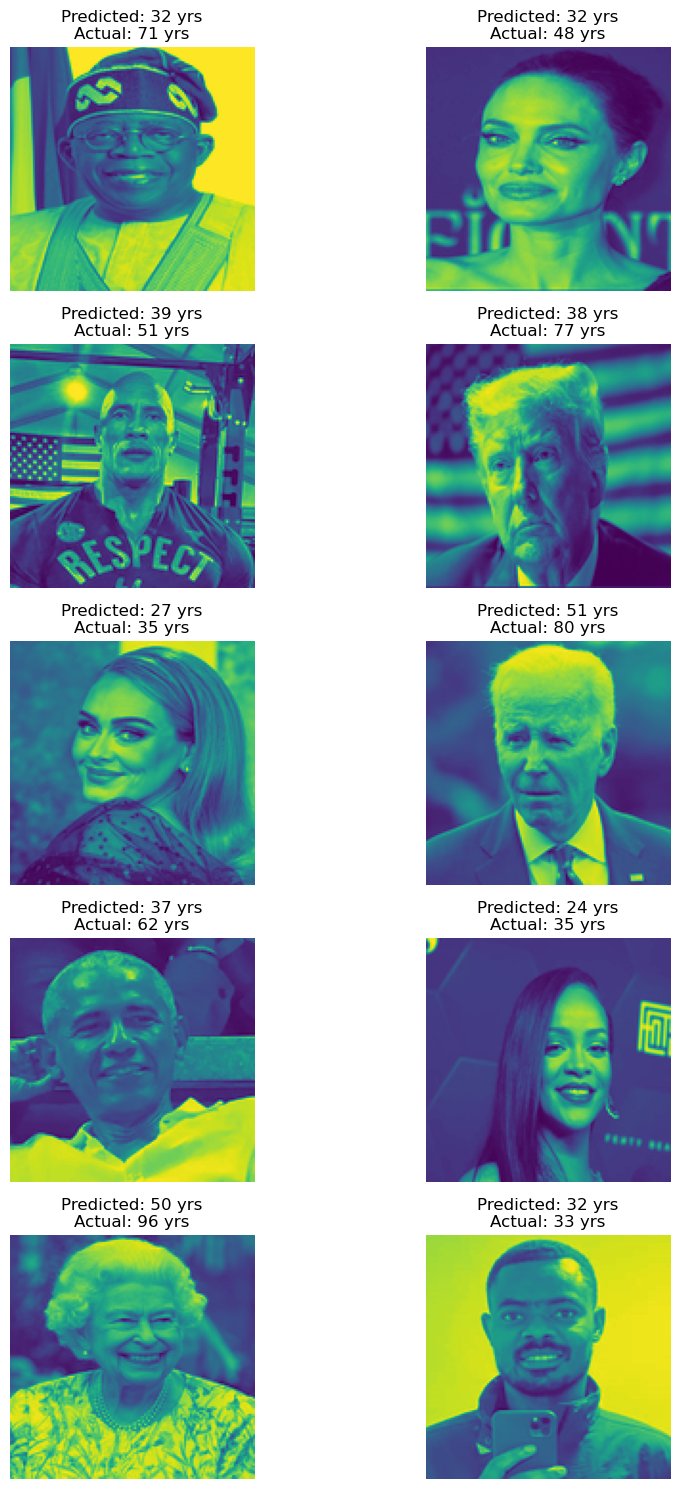

In [110]:
# List of test image file names and actual ages
test_images = [
    {"file_name": "tinubu_gray.jpg", "actual_age": 71},
    {"file_name": "angelina_jolie_gray.jpg", "actual_age": 48},
    {"file_name": "dwayne_johnson_gray.jpg", "actual_age": 51},
    {"file_name": "donald_trump_gray.jpg", "actual_age": 77},
    {"file_name": "adele_gray.jpg", "actual_age": 35},
    {"file_name": "joe_biden_gray.jpg", "actual_age": 80},
    {"file_name": "obama_gray.jpg", "actual_age": 62},
    {"file_name": "rihanna_gray.jpg", "actual_age": 35},
    {"file_name": "queen_elizabeth_gray.jpg", "actual_age": 96},
    {"file_name": "martins_gray.jpg", "actual_age": 33}
]

# Calculate the number of rows and columns for the subplot grid
num_images = len(test_images)
num_rows = (num_images + 1) // 2  # Adjusted for odd number of images
num_cols = 2

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Initialize a counter for subplot placement
plot_counter = 0

# Loop through test images
for test_image_info in test_images:
    # Load and preprocess the test image
    image_path = test_image_info["file_name"]
    test_image = Image.open(image_path)
    test_image = test_image.resize((128, 128), Image.LANCZOS)
    test_image_array = img_to_array(test_image)
    test_image_array = test_image_array / 255.0
    test_image_flat = test_image_array.reshape(1, -1)

    # Make the age prediction using the SVM model
    predicted_age = svm_model.predict(test_image_flat)[0]

    # Actual age of the test image
    actual_age = test_image_info["actual_age"]

    # Display the image with predicted and actual age as label
    axs[plot_counter // 2, plot_counter % 2].imshow(test_image)
    axs[plot_counter // 2, plot_counter % 2].set_title(f"Predicted: {int(predicted_age)} yrs\nActual: {actual_age} yrs")
    axs[plot_counter // 2, plot_counter % 2].axis('off')

    # Increment the subplot counter
    plot_counter += 1

# If there is an odd number of images, remove the empty subplot
if num_images % 2 != 0:
    fig.delaxes(axs[num_rows - 1, num_cols - 1])

# Show the subplot grid
plt.tight_layout()
plt.savefig("SVM_Age_Prediction_with_Images.png")
plt.show()


In [116]:
# Print the hyperparameters of the SVM model
print("Support Vector Machine (SVM) Hyperparameters:")
print("Kernel:", svm_model.kernel)
print("C:", svm_model.C)
print("Degree:", svm_model.degree) 


Support Vector Machine (SVM) Hyperparameters:
Kernel: rbf
C: 1.0
Degree: 3


### Result Compilation

In [130]:
# Combine the DataFrames into a single DataFrame for the first 10 rows
combined_df = pd.concat([cnn_comparison_ds.head(10), svm_comparison_df.head(10), rfr_comparison_df.head(10)], axis=1)

# Display the first few rows of the combined DataFrame
combined_df = combined_df.loc[:,~combined_df.columns.duplicated()]

# Display the DataFrame without duplicate columns
combined_df

Actual Age  Predicted Age (CNN)  Predicted Age (SVM)  \
1474           19                 19.0                 23.0   
19472          56                 34.0                 29.0   
19788          58                 26.0                 31.0   
9526           29                 24.0                 37.0   
4788           24                 21.0                 27.0   
18217          51                 37.0                 31.0   
3100           21                 19.0                 30.0   
13361          35                 28.0                 34.0   
14084          37                 57.0                 34.0   
14798          39                 50.0                 31.0   

       Predicted Age (RFR)  
1474                  29.0  
19472                 30.0  
19788                 39.0  
9526                  34.0  
4788                  41.0  
18217                 35.0  
3100                  32.0  
13361                 31.0  
14084                 33.0  
14798                 35.0

In [131]:
# Create a dictionary to store the evaluation metrics
data = {
    "Model": ["CNN", "Support Vector Machine", "Random Forest Regression"],
    'MAE Train': [4.13, 10.47, 12.44],
    'MAE Test': [6.93, 10.89, 12.77],
    'MSE Train': [29.83, 218.81, 262.24],
    'MSE Test': [90.22, 234.46, 282.16],
    'RMSE Train': [5.46, 14.79, 16.19],
    'RMSE Test': [9.50, 15.31, 16.80],
    'R^2 Train': [0.92, 0.44, 0.33],
    'R^2 Test': [0.77, 0.41, 0.29]
}

# Create a DataFrame
comparison_ds = pd.DataFrame(data)
comparison_ds


Model  MAE Train  MAE Test  MSE Train  MSE Test  \
0                       CNN       4.13      6.93      29.83     90.22   
1    Support Vector Machine      10.47     10.89     218.81    234.46   
2  Random Forest Regression      12.44     12.77     262.24    282.16   

   RMSE Train  RMSE Test  R^2 Train  R^2 Test  
0        5.46       9.50       0.92      0.77  
1       14.79      15.31       0.44      0.41  
2       16.19      16.80       0.33      0.29